#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [ ]:
import zipfile
import os

zip_file_path = "archive.zip"
extract_dir = "archive_ex"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(extract_dir)

In [ ]:
import torch
import os

dataset_path = os.path.join("archive_ex")

image_dataset_path = os.path.join(dataset_path, "jpeg_images")
mask_dataset_path = os.path.join(dataset_path, "jpeg_masks")

test_split = 0.15

device = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if device == "cuda" else False

num_channels = 1
num_classes = 1
num_levels = 3
batch_size = 64


init_lr = 0.001
num_epochs = 40
threshold = 0.5
base_out = "output"

height = 128
width = 128

MODEL_PATH = os.path.join(base_out, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([base_out, "plot.png"])
TEST_PATHS = os.path.sep.join([base_out, "test_paths.txt"])



In [ ]:
import cv2

class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, imagePaths, maskPaths, img_transf, msk_transf):
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.img_transf = img_transf
    self.msk_transf = msk_transf

  def __len__(self):
    return(len(self.imagePaths))

  def __getitem__(self, idx):
    imagePath = self.imagePaths[idx]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)

    if self.img_transf:
      image = self.img_transf(image)
    if self.msk_transf:
      mask = self.msk_transf(mask)

    # print(torch.unique(mask), mask.dtype, mask.min().item(), mask.max().item())


    if isinstance(mask, torch.Tensor) and mask.ndim == 2:
        mask = mask.unsqueeze(0)

    return (image, mask)


In [ ]:
from imutils import paths

imagePaths = sorted(list(paths.list_images(image_dataset_path)))
maskPaths = sorted(list(paths.list_images(mask_dataset_path)))


dataset = SegmentationDataset(imagePaths=imagePaths,
                               maskPaths=maskPaths,
                               img_transf=None, msk_transf=None)

img, msk = dataset[0]
print("Image  shape / dtype:", img.shape, img.dtype)
print("Mask   shape / dtype:", msk.shape, msk.dtype)

Image  shape / dtype: (825, 550, 3) uint8
Mask   shape / dtype: (825, 550) uint8


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [ ]:
import numpy as np

def show_image_with_mask(image, mask):

    if isinstance(image, torch.Tensor):
      image = image.permute(1, 2, 0).cpu().numpy()

    if isinstance(mask, torch.Tensor):
      if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)
      mask = mask.cpu().numpy()

    if image.dtype in [np.float32, np.float64]:
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


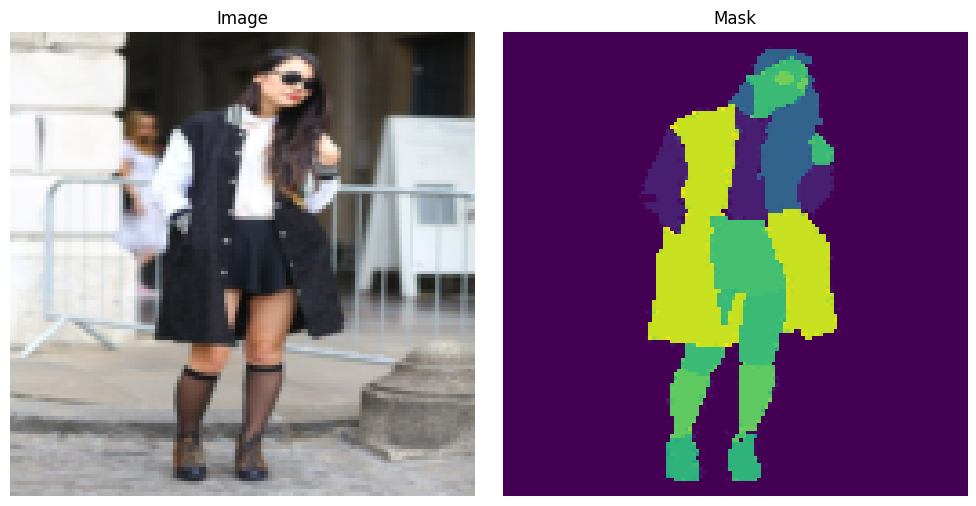

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
from PIL import Image

imagePaths = sorted(list(paths.list_images(image_dataset_path)))
maskPaths = sorted(list(paths.list_images(mask_dataset_path)))


img_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((height, width), interpolation=Image.BILINEAR),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((height, width), interpolation=Image.NEAREST),
    T.PILToTensor(),
    T.Lambda(lambda x: x.squeeze(0).long())
])


dataset = SegmentationDataset(imagePaths=imagePaths,
                               maskPaths=maskPaths,
                               img_transf=img_transform, msk_transf=mask_transform)

image, mask = dataset[0]

show_image_with_mask(image, mask)





<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [ ]:
from torch import nn

class Block(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, 3)

  def forward(self, x):

    return self.conv2(self.relu(self.conv1(x)))

In [ ]:
class Encoder(nn.Module):
  def __init__(self, channels=(3, 16, 32, 64)):
    super().__init__()
    self.encBlocks = nn.ModuleList(
        [Block(channels[i], channels[i + 1])
          for i in range(len(channels) - 1)]
    )
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    blockOutputs = []

    for block in self.encBlocks:
      x = block(x)
      blockOutputs.append(x)
      x = self.pool(x)
    return blockOutputs


In [ ]:
from torchvision.transforms import CenterCrop

class Decoder(nn.Module):
  def __init__(self, channels=(64, 32, 16)):
    super().__init__()

    self.channels = channels
    self.upconvs = nn.ModuleList(
        [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
        for i in range(len(channels) - 1)])
    self.dec_blocks = nn.ModuleList(
        [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])

  def forward(self, x, encFeatures):
    for i in range(len(self.channels) - 1):
      x = self.upconvs[i](x)
      encFeat = self.crop(encFeatures[i], x)
      x = torch.cat([x, encFeat], dim=1)
      x = self.dec_blocks[i](x)

    return x

  def crop(self, encFeatures, x):

    (_, _, H, W) = x.shape
    encFeatures = CenterCrop([H, W])(encFeatures)

    return encFeatures



In [ ]:
from torch.nn import functional as F

class UNet(nn.Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
               decChannels=(64, 32, 16),
               nbClasses=1, retainDim=True,
               outSize=(height, width)):
    super().__init__()
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)

    self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize


  def forward(self, x):

    encFeatures = self.encoder(x)
    decFeatures = self.decoder(encFeatures[::-1][0],
                              encFeatures[::-1][1:])
    map = self.head(decFeatures)

    if self.retainDim:
      map = F.interpolate(map, self.outSize)

    return map



In [ ]:
class DoubleConv(nn.Module):
    """Conv-BN-ReLU ×2  (padding=1 сохраняет размер)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetLite(nn.Module):
    def __init__(self, n_classes, in_ch=3, base=32, depth=4):
        super().__init__()
        ch = [base * 2**k for k in range(depth+1)]
        self.inc   = DoubleConv(in_ch, ch[0])
        self.downs = nn.ModuleList([
            nn.Sequential(nn.MaxPool2d(2), DoubleConv(ch[i], ch[i+1]))
            for i in range(depth)
        ])
        self.ups = nn.ModuleList([
            nn.ConvTranspose2d(ch[i+1], ch[i], 2, stride=2)
            for i in reversed(range(depth))
        ])
        self.dec_blocks = nn.ModuleList([
            DoubleConv(ch[i+1], ch[i])
            for i in reversed(range(depth))
        ])
        self.head = nn.Conv2d(ch[0], n_classes, 1)

    def forward(self, x):
        skips = [self.inc(x)]
        for down in self.downs:
            skips.append(down(skips[-1]))
        x = skips.pop()
        for up, dec in zip(self.ups, self.dec_blocks):
            skip = skips.pop()
            x = up(x)
            if x.shape != skip.shape:
                diffY = skip.size(2) - x.size(2)
                diffX = skip.size(3) - x.size(3)
                skip = skip[:, :, diffY//2:skip.size(2)-diffY+diffY//2,
                               diffX//2:skip.size(3)-diffX+diffX//2]
            x = dec(torch.cat([skip, x], dim=1))
        return self.head(x)


In [ ]:
import numpy as np
import cv2

def count_unique_classes(maskPaths):
    unique_classes = set()
    for path in maskPaths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        unique_classes.update(np.unique(mask))
    return len(unique_classes)

In [ ]:
import torchvision.transforms as T

img_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((height, width), interpolation=Image.BILINEAR),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((height, width), interpolation=Image.NEAREST),
    T.PILToTensor(),
    T.Lambda(lambda x: x.squeeze(0).long())
])


dataset = SegmentationDataset(
    imagePaths=imagePaths,
    maskPaths=maskPaths,
    img_transf=img_transform,
    msk_transf=mask_transform
)

n_classes = count_unique_classes(maskPaths)
print("n_classes =", n_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = UNetLite(n_classes=n_classes).to(device)

img, mask = dataset[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(img)
print("Logits shape:", logits.shape)

print(mask.unique())


n_classes = 66
Logits shape: torch.Size([1, 66, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 26, 27, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

RNG      = 42
val_part = test_split

train_img, val_img, train_msk, val_msk = train_test_split(
        imagePaths, maskPaths,
        test_size = val_part,
        random_state = RNG,
        shuffle = True)

train_ds = SegmentationDataset(train_img, train_msk,
                               img_transform, mask_transform)
val_ds   = SegmentationDataset(val_img,   val_msk,
                               img_transform, mask_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True,  pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                          shuffle=False, pin_memory=PIN_MEMORY)


NameError: name 'test_split' is not defined

In [ ]:
def compute_class_weights(mask_paths, n_cls):
    counts = np.zeros(n_cls)
    for p in mask_paths:
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        for c in range(n_cls): counts[c] += np.sum(m == c)
    weights = counts.max() / (counts + 1e-6)
    return torch.tensor(weights, dtype=torch.float32)

weights = compute_class_weights(train_msk, n_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torch.optim import Adam
from tqdm.auto import tqdm

@torch.no_grad()
def multiclass_dice(logits, target, eps=1e-7):
    prob  = torch.softmax(logits,1)
    pred  = torch.argmax(prob,1)
    dice_total = 0; valid_cls = 0
    for c in range(1, logits.shape[1]):
        pred_c = (pred==c).float()
        targ_c = (target==c).float()
        if targ_c.sum() == 0 and pred_c.sum() == 0:
            continue
        inter = (pred_c*targ_c).sum()
        union = pred_c.sum() + targ_c.sum()
        dice_total += (2*inter+eps)/(union+eps)
        valid_cls  += 1
    return dice_total/valid_cls if valid_cls>0 else torch.tensor(1.0)


EPOCHS = 40
for epoch in range(1, EPOCHS+1):

    model.train()
    tr_loss = tr_dice = 0
    for imgs, msks in tqdm(train_loader, leave=False):
        imgs, msks = imgs.to(device), msks.squeeze(1).to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, msks)
        loss.backward()
        optimizer.step()
        bs = imgs.size(0)
        tr_loss += loss.item()*bs
        tr_dice += multiclass_dice(out, msks).item()*bs
    tr_loss /= len(train_loader.dataset)
    tr_dice /= len(train_loader.dataset)


    model.eval()
    vl_loss = vl_dice = 0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device), msks.squeeze(1).to(device)
            out = model(imgs)
            vl_loss += criterion(out, msks).item()*imgs.size(0)
            vl_dice += multiclass_dice(out, msks).item()*imgs.size(0)
    vl_loss /= len(val_loader.dataset)
    vl_dice /= len(val_loader.dataset)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss {tr_loss:.4f} dice {tr_dice:.4f} | "
          f"val: loss {vl_loss:.4f} dice {vl_dice:.4f}")


def show_triplet(image_t, gt_t, pred_t):
    """image_t (3,H,W) float; gt/pred (H,W) long"""
    img  = image_t.permute(1,2,0).cpu().numpy()
    img  = (np.clip(img,0,1)*255).astype(np.uint8)
    gt   = gt_t.cpu().numpy()
    pr   = pred_t.cpu().numpy()

    fig,ax = plt.subplots(1,3, figsize=(10,4))
    ax[0].imshow(img); ax[0].set_title("Image"); ax[0].axis("off")
    ax[1].imshow(gt);  ax[1].set_title("GT mask"); ax[1].axis("off")
    ax[2].imshow(pr);  ax[2].set_title("Pred"); ax[2].axis("off")
    plt.tight_layout(); plt.show()



  0%|          | 0/14 [00:00<?, ?it/s]

[01/40] train: loss 4.2174 dice 0.0059 | val: loss 4.1635 dice 0.0015


  0%|          | 0/14 [00:00<?, ?it/s]

[02/40] train: loss 4.1364 dice 0.0085 | val: loss 4.1800 dice 0.0056


  0%|          | 0/14 [00:00<?, ?it/s]

[03/40] train: loss 4.0775 dice 0.0115 | val: loss 4.1647 dice 0.0115


  0%|          | 0/14 [00:00<?, ?it/s]

[04/40] train: loss 4.0027 dice 0.0157 | val: loss 4.1315 dice 0.0154


  0%|          | 0/14 [00:00<?, ?it/s]

[05/40] train: loss 3.9100 dice 0.0176 | val: loss 4.4192 dice 0.0074


  0%|          | 0/14 [00:00<?, ?it/s]

[06/40] train: loss 3.8066 dice 0.0217 | val: loss 4.2263 dice 0.0148


  0%|          | 0/14 [00:00<?, ?it/s]

[07/40] train: loss 3.7237 dice 0.0289 | val: loss 7.9958 dice 0.0074


  0%|          | 0/14 [00:00<?, ?it/s]

[08/40] train: loss 3.6490 dice 0.0316 | val: loss 3.9283 dice 0.0289


  0%|          | 0/14 [00:00<?, ?it/s]

[09/40] train: loss 3.5418 dice 0.0406 | val: loss 3.9833 dice 0.0365


  0%|          | 0/14 [00:00<?, ?it/s]

[10/40] train: loss 3.4395 dice 0.0464 | val: loss 3.8567 dice 0.0418


  0%|          | 0/14 [00:00<?, ?it/s]

[11/40] train: loss 3.3531 dice 0.0522 | val: loss 3.8099 dice 0.0530


  0%|          | 0/14 [00:00<?, ?it/s]

[12/40] train: loss 3.2828 dice 0.0589 | val: loss 3.7956 dice 0.0515


  0%|          | 0/14 [00:00<?, ?it/s]

[13/40] train: loss 3.2318 dice 0.0620 | val: loss 3.8003 dice 0.0497


  0%|          | 0/14 [00:00<?, ?it/s]

[14/40] train: loss 3.2104 dice 0.0636 | val: loss 3.9979 dice 0.0518


  0%|          | 0/14 [00:00<?, ?it/s]

[15/40] train: loss 3.1568 dice 0.0697 | val: loss 4.0101 dice 0.0478


  0%|          | 0/14 [00:00<?, ?it/s]

[16/40] train: loss 3.0942 dice 0.0735 | val: loss 3.8230 dice 0.0590


  0%|          | 0/14 [00:00<?, ?it/s]

[17/40] train: loss 3.0517 dice 0.0755 | val: loss 4.1102 dice 0.0580


  0%|          | 0/14 [00:00<?, ?it/s]

[18/40] train: loss 2.9897 dice 0.0829 | val: loss 3.8444 dice 0.0651


  0%|          | 0/14 [00:00<?, ?it/s]

[19/40] train: loss 2.9466 dice 0.0888 | val: loss 3.9019 dice 0.0726


  0%|          | 0/14 [00:00<?, ?it/s]

[20/40] train: loss 2.8923 dice 0.0922 | val: loss 4.0267 dice 0.0668


  0%|          | 0/14 [00:00<?, ?it/s]

[21/40] train: loss 2.8447 dice 0.0989 | val: loss 4.1005 dice 0.0579


  0%|          | 0/14 [00:00<?, ?it/s]

[22/40] train: loss 2.8281 dice 0.1020 | val: loss 3.9696 dice 0.0730


  0%|          | 0/14 [00:00<?, ?it/s]

[23/40] train: loss 2.7842 dice 0.1081 | val: loss 4.5969 dice 0.0390


  0%|          | 0/14 [00:00<?, ?it/s]

[24/40] train: loss 2.7755 dice 0.1085 | val: loss 4.0819 dice 0.0818


  0%|          | 0/14 [00:00<?, ?it/s]

[25/40] train: loss 2.7078 dice 0.1105 | val: loss 4.1440 dice 0.0655


  0%|          | 0/14 [00:00<?, ?it/s]

[26/40] train: loss 2.6321 dice 0.1275 | val: loss 4.0384 dice 0.0868


  0%|          | 0/14 [00:00<?, ?it/s]

[27/40] train: loss 2.6216 dice 0.1262 | val: loss 4.1548 dice 0.0830


  0%|          | 0/14 [00:00<?, ?it/s]

[28/40] train: loss 2.5773 dice 0.1344 | val: loss 4.1946 dice 0.0766


  0%|          | 0/14 [00:00<?, ?it/s]

[29/40] train: loss 2.5839 dice 0.1262 | val: loss 4.0710 dice 0.0803


  0%|          | 0/14 [00:00<?, ?it/s]

[30/40] train: loss 2.5369 dice 0.1410 | val: loss 4.1889 dice 0.0866


  0%|          | 0/14 [00:00<?, ?it/s]

[31/40] train: loss 2.4805 dice 0.1411 | val: loss 4.4151 dice 0.0758


  0%|          | 0/14 [00:00<?, ?it/s]

[32/40] train: loss 2.4706 dice 0.1430 | val: loss 4.2900 dice 0.0679


  0%|          | 0/14 [00:00<?, ?it/s]

[33/40] train: loss 2.4513 dice 0.1510 | val: loss 4.3663 dice 0.0730


  0%|          | 0/14 [00:00<?, ?it/s]

[34/40] train: loss 2.4261 dice 0.1519 | val: loss 4.2521 dice 0.0725


  0%|          | 0/14 [00:00<?, ?it/s]

[35/40] train: loss 2.3553 dice 0.1624 | val: loss 4.2598 dice 0.0810


  0%|          | 0/14 [00:00<?, ?it/s]

[36/40] train: loss 2.2820 dice 0.1840 | val: loss 4.4994 dice 0.0864


  0%|          | 0/14 [00:00<?, ?it/s]

[37/40] train: loss 2.2461 dice 0.1862 | val: loss 4.4359 dice 0.0894


  0%|          | 0/14 [00:00<?, ?it/s]

[38/40] train: loss 2.1985 dice 0.2007 | val: loss 4.7283 dice 0.0788


  0%|          | 0/14 [00:00<?, ?it/s]

[39/40] train: loss 2.1437 dice 0.2111 | val: loss 4.4304 dice 0.0919


  0%|          | 0/14 [00:00<?, ?it/s]

[40/40] train: loss 2.1055 dice 0.2146 | val: loss 4.7023 dice 0.0933


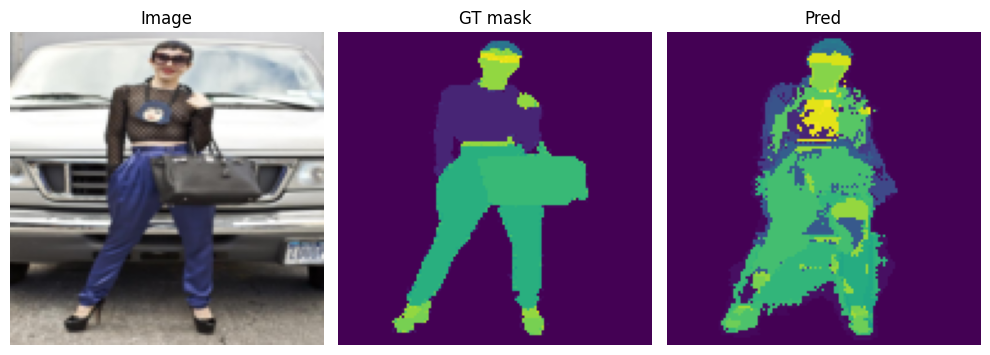

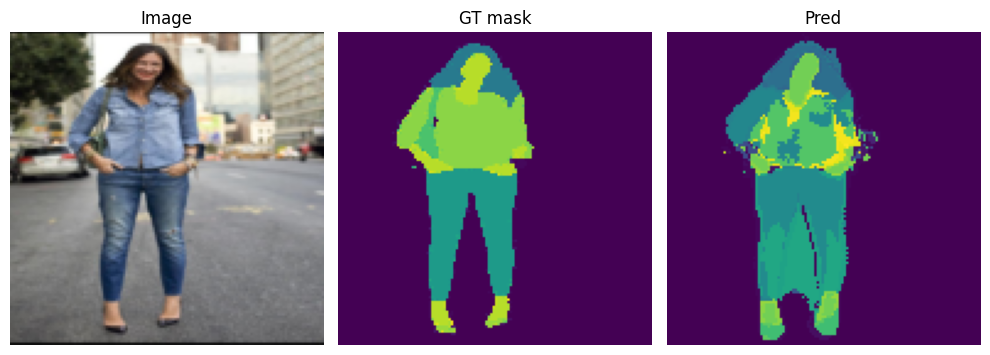

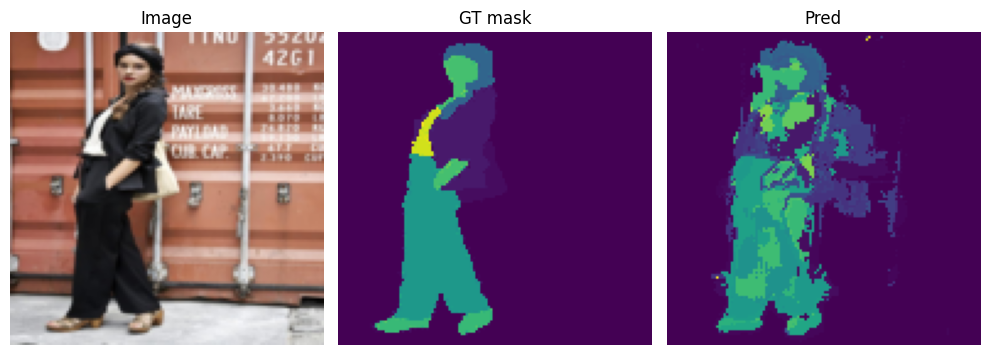

In [ ]:
import random

model.eval()
samples = random.sample(range(len(val_ds)), 3)
with torch.no_grad():
    for idx in samples:
        img, gt = val_ds[idx]
        logits  = model(img.unsqueeze(0).to(device))
        pred    = torch.argmax(logits,1)[0].cpu()
        show_triplet(img, gt.squeeze(0), pred)

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 61
num_epochs = 5
lr = 5e-5

processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512", reduce_labels=False)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def pixel_accuracy(preds, masks):
    preds = F.interpolate(preds, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(preds, dim=1)
    valid = masks >= 0
    correct = (preds == masks) & valid
    return correct.sum().float() / valid.sum().float()

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for imgs, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Train"):
        imgs, masks = imgs.to(device), masks.to(device).long().squeeze(1)
        outputs = model(pixel_values=imgs)
        logits = outputs.logits
        logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        loss = F.cross_entropy(logits, masks, ignore_index=255)

        acc = pixel_accuracy(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_acc/len(train_loader):.4f}")


    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validation"):
            imgs, masks = imgs.to(device), masks.to(device).long().squeeze(1)
            outputs = model(pixel_values=imgs)
            logits = outputs.logits
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            loss = F.cross_entropy(logits, masks)
            acc = pixel_accuracy(logits, masks)

            val_loss += loss.item()
            val_acc += acc.item()

    print(f"Val   Loss: {val_loss/len(val_loader):.4f} | Accuracy: {val_acc/len(val_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([61]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([61, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'train_loader' is not defined

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


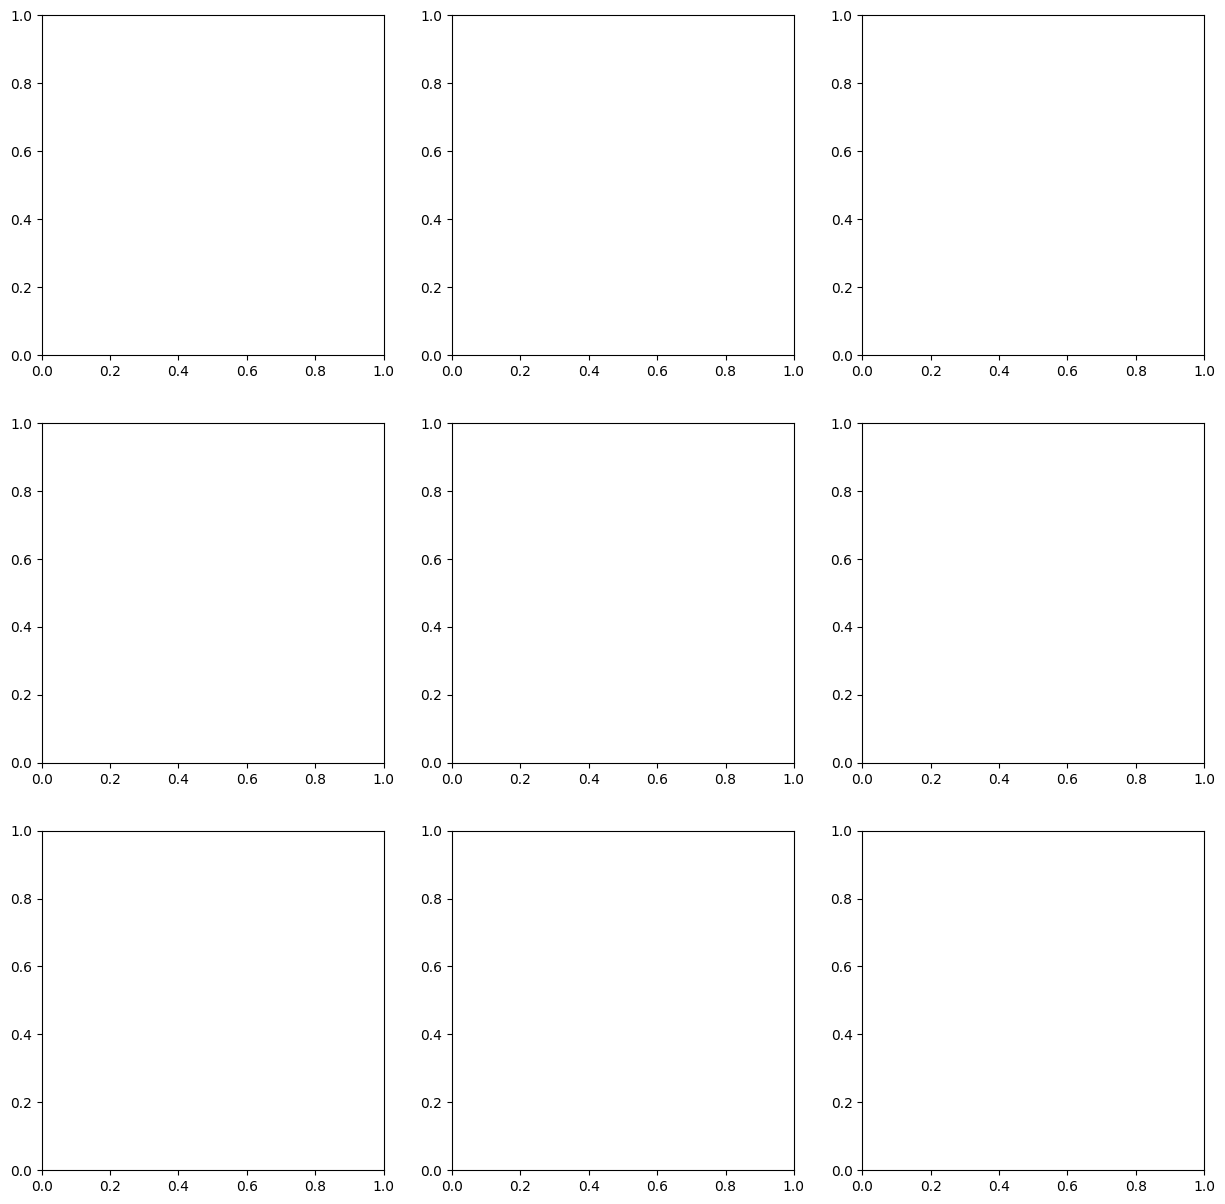

In [ ]:
def show_predictions(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        image, true_mask = dataset[i]
        with torch.no_grad():
            output = model(pixel_values=image.unsqueeze(0).to(device))
            logits = output.logits
            pred_mask = torch.argmax(F.interpolate(logits, size=true_mask.shape[-2:], mode="bilinear", align_corners=False), dim=1)
            pred_mask = pred_mask.squeeze().cpu()

        img_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = true_mask.squeeze().cpu().numpy()

        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(mask_np)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(pred_mask)
        axes[i, 2].set_title("Prediction")

    plt.tight_layout()
    plt.show()

# Покажем предсказания
show_predictions(model, val_ds, num_samples=3)


